### Project-Low Yin Jin | 2101663I |PE01

### Q2

In [1]:
import warnings
warnings.simplefilter(action= 'ignore', category= FutureWarning)

In [2]:
import numpy as np
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### Loading Data

In [3]:
batch_size= 32
img_height= 224
img_width= 224

#this is the augmentation configuration 
train_datagen= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                fill_mode='nearest')

val_datagen= ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(
        './dataset/PartB/training/', 
        target_size= (img_width, img_height),  
        batch_size= batch_size,
        class_mode= 'categorical')  #use categorical_crossentropy loss for multi-class


#this is a similar generator, for validation data
validation_generator= val_datagen.flow_from_directory(
        './dataset/PartB/validation/',
        target_size= (img_width, img_height),  
        batch_size= batch_size,
        class_mode= 'categorical')


Found 3779 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.


Tensor shape with batch 32:  (32, 224, 224, 3)


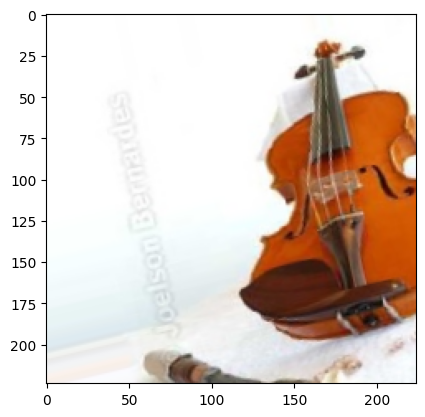

In [4]:
#Tensor shape of images generated by ImageGenerator
print("Tensor shape with batch 32: ", train_generator[0][0].shape)

image= train_generator[0][0][0]
plt.imshow(image)

Tensor shape with batch 32:  (32, 224, 224, 3)


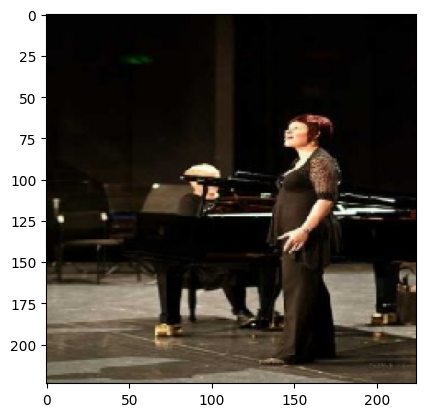

In [5]:
#Tensor shape of images generated by ImageGenerator
print("Tensor shape with batch 32: ", validation_generator[0][0].shape)

image= validation_generator[0][0][0]
plt.imshow(image)

In [6]:
labels= (train_generator.class_indices)
labels= dict((v,k) for k,v in labels.items())
print(labels)

num_classes= len(labels)

{0: 'drum', 1: 'guitar', 2: 'piano', 3: 'violin'}


In [7]:
early_stop= EarlyStopping(monitor='val_loss', patience=5, verbose=1)

### Model

In [8]:
#Load the InceptionV3 model
inceptionV3= InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

#Freeze the base model layers
for layer in inceptionV3.layers:
    layer.trainable= False

#Define the new top model
x= inceptionV3.output
x= GlobalAveragePooling2D()(x)
x= Dense(1024, activation='relu')(x)
x= Dropout(0.5)(x)
predictions= Dense(num_classes, activation='softmax')(x)

#Define the final model
model= Model(inputs=inceptionV3.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history= model.fit(train_generator, validation_data=validation_generator, epochs= 50, verbose=1, callbacks= early_stop)

Epoch 1/50
119/119 [==============================] - 253s 2s/step - loss: 0.4436 - accuracy: 0.8325 - val_loss: 0.1253 - val_accuracy: 0.9614
Epoch 2/50
119/119 [==============================] - 260s 2s/step - loss: 0.3125 - accuracy: 0.8883 - val_loss: 0.1263 - val_accuracy: 0.9579
Epoch 3/50
119/119 [==============================] - 255s 2s/step - loss: 0.2780 - accuracy: 0.8994 - val_loss: 0.1104 - val_accuracy: 0.9657
Epoch 4/50
119/119 [==============================] - 253s 2s/step - loss: 0.2679 - accuracy: 0.9063 - val_loss: 0.1122 - val_accuracy: 0.9664
Epoch 5/50
119/119 [==============================] - 242s 2s/step - loss: 0.2485 - accuracy: 0.9132 - val_loss: 0.1141 - val_accuracy: 0.9643
Epoch 6/50
119/119 [==============================] - 201s 2s/step - loss: 0.2303 - accuracy: 0.9164 - val_loss: 0.1025 - val_accuracy: 0.9700
Epoch 7/50
119/119 [==============================] - 250s 2s/step - loss: 0.2483 - accuracy: 0.9082 - val_loss: 0.1042 - val_accuracy: 0.9693

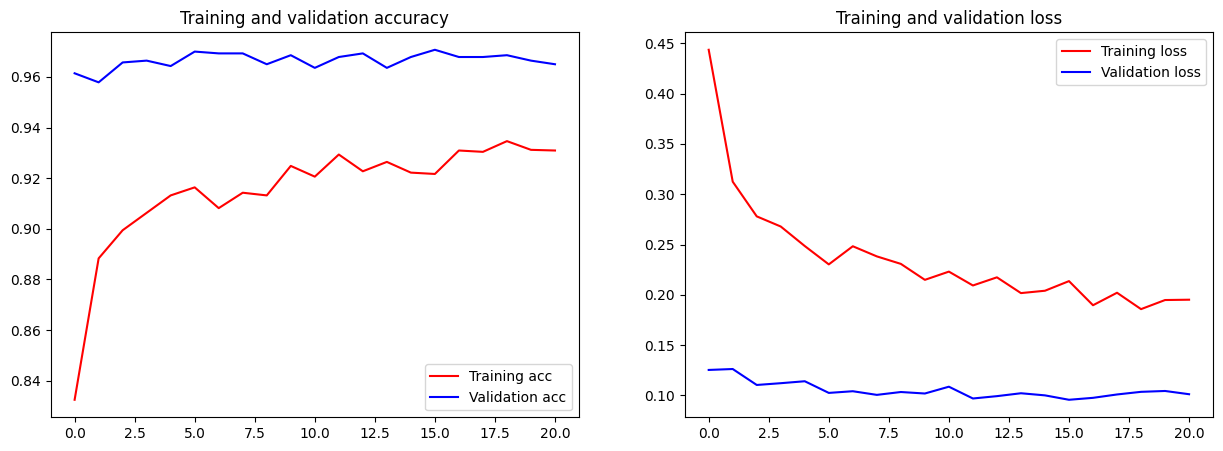

In [11]:
#Extract the accuracy and loss from the history object
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

#Get the number of epochs
epochs= range(len(acc))

#Plot the training and validation accuracy and loss
fig, axs= plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(epochs, acc, 'r', label='Training acc')
axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].legend()

axs[1].plot(epochs, loss, 'r', label='Training loss')
axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].legend()
plt.show()

In [12]:
#Evaluate the model
scores= model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

44/44 [==============================] - 55s 1s/step - loss: 0.1012 - accuracy: 0.9650
Accuracy: 96.50%


In [13]:
model.save("model/InceptionV3Adam.h5") 
print("Saved model to disk")

Saved model to disk


In [14]:
json_model= model.to_json()

with open("model/InceptionV3Adam.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("model/InceptionV3Adam_weights.h5")

In [28]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history= model.fit(train_generator, validation_data=validation_generator, epochs= 50, verbose=1, callbacks= early_stop)

Epoch 1/50
119/119 [==============================] - 295s 2s/step - loss: 0.1855 - accuracy: 0.9307 - val_loss: 0.0949 - val_accuracy: 0.9736
Epoch 2/50
119/119 [==============================] - 343s 3s/step - loss: 0.1714 - accuracy: 0.9360 - val_loss: 0.0948 - val_accuracy: 0.9729
Epoch 3/50
119/119 [==============================] - 250s 2s/step - loss: 0.1678 - accuracy: 0.9373 - val_loss: 0.0957 - val_accuracy: 0.9714
Epoch 4/50
119/119 [==============================] - 351s 3s/step - loss: 0.1746 - accuracy: 0.9315 - val_loss: 0.0955 - val_accuracy: 0.9714
Epoch 5/50
119/119 [==============================] - 288s 2s/step - loss: 0.1743 - accuracy: 0.9415 - val_loss: 0.0957 - val_accuracy: 0.9707
Epoch 6/50
119/119 [==============================] - 355s 3s/step - loss: 0.1708 - accuracy: 0.9413 - val_loss: 0.0959 - val_accuracy: 0.9700
Epoch 7/50
119/119 [==============================] - 310s 3s/step - loss: 0.1710 - accuracy: 0.9362 - val_loss: 0.0961 - val_accuracy: 0.9700

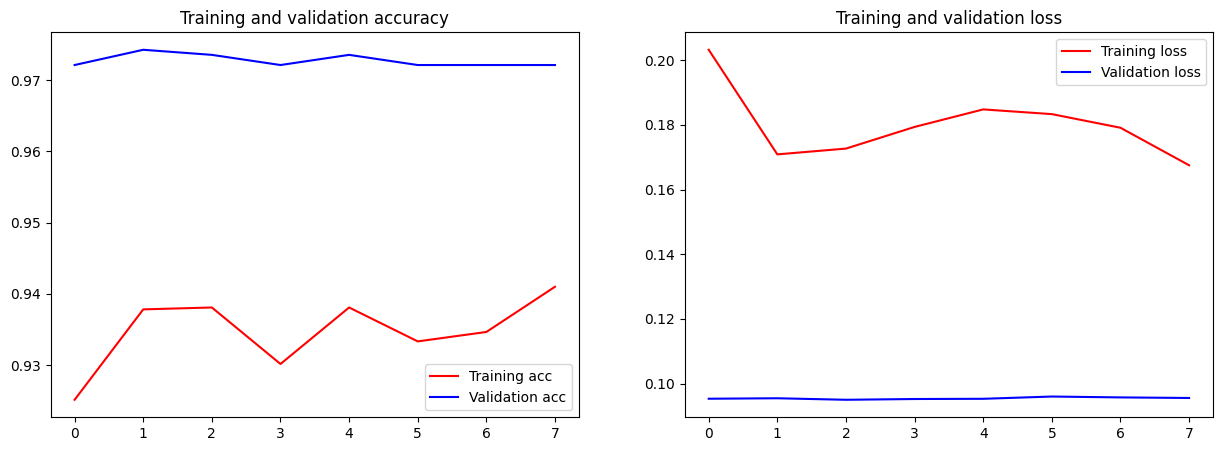

In [17]:
#Extract the accuracy and loss from the history object
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

#Get the number of epochs
epochs= range(len(acc))

#Plot the training and validation accuracy and loss
fig, axs= plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(epochs, acc, 'r', label='Training acc')
axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].legend()

axs[1].plot(epochs, loss, 'r', label='Training loss')
axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].legend()
plt.show()

In [18]:
#Evaluate the model
scores= model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

44/44 [==============================] - 43s 982ms/step - loss: 0.0955 - accuracy: 0.9721
Accuracy: 97.21%


In [19]:
model.save("model/InceptionV3GSD.h5") 
print("Saved model to disk")

Saved model to disk


In [20]:
json_model= model.to_json()

with open("model/InceptionV3SGD.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("model/InceptionV3SGD_weights.h5")

In [21]:
import numpy as np
import IPython.display as display
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [22]:
#Load the previously saved model
model= tf.keras.models.load_model("./model/InceptionV3Adam.h5")
#Define the class labels
labels= {0: 'drum', 1: 'guitar', 2: 'piano', 3: 'violin'}

c:\Users\lowyi\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


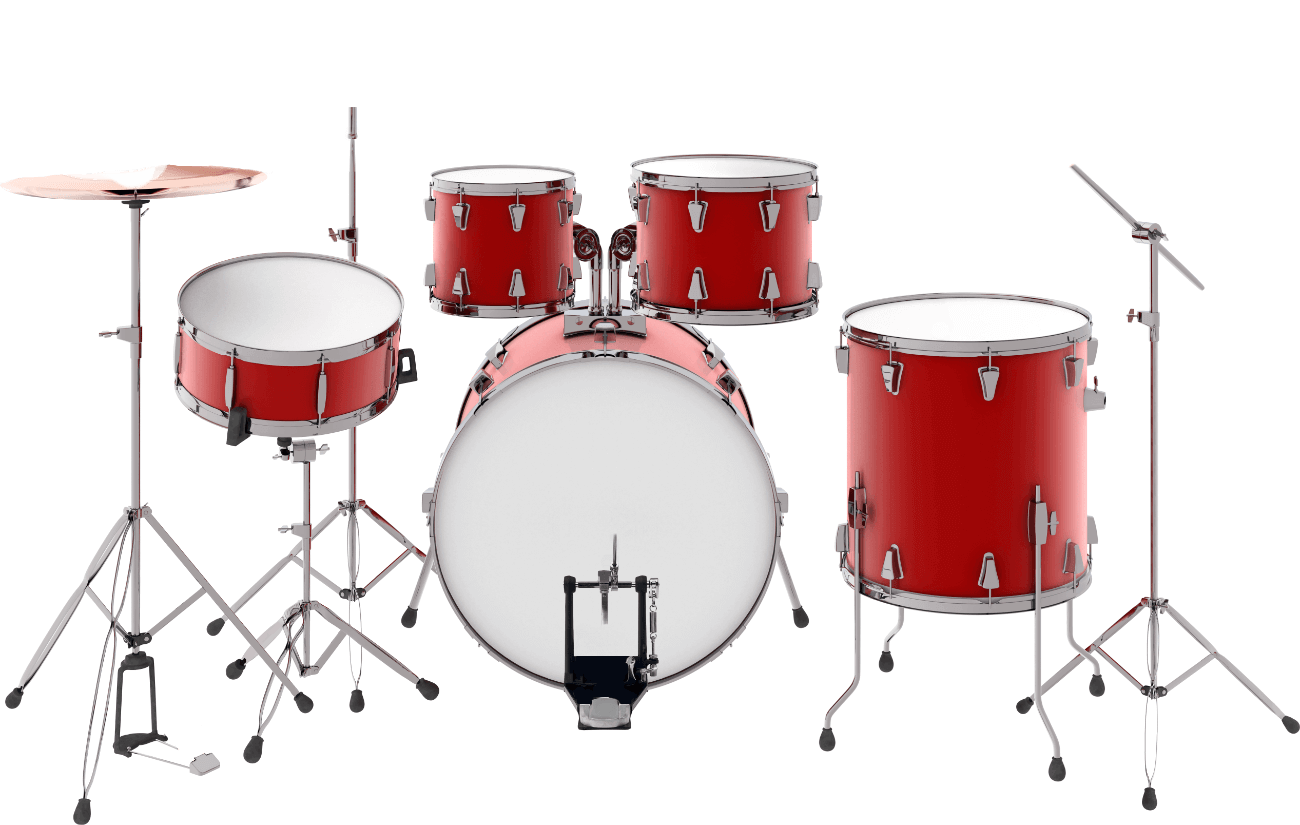

Predicted class: drum with a 47.54


In [23]:
test= './dataset/PartB/testing/drum1.png'
#Test the model on a new image
img= image.load_img(test, target_size=(224, 224))
img_array= image.img_to_array(img)
img_array= np.expand_dims(img_array, axis=0)
img_array= img_array/255

prediction= model.predict(img_array)
score= tf.nn.softmax(prediction)

#Show the image
display.display(display.Image(test))
print("Predicted class: {} with a {:.2f}".format(labels[np.argmax(score)], 100 * np.max(score)))

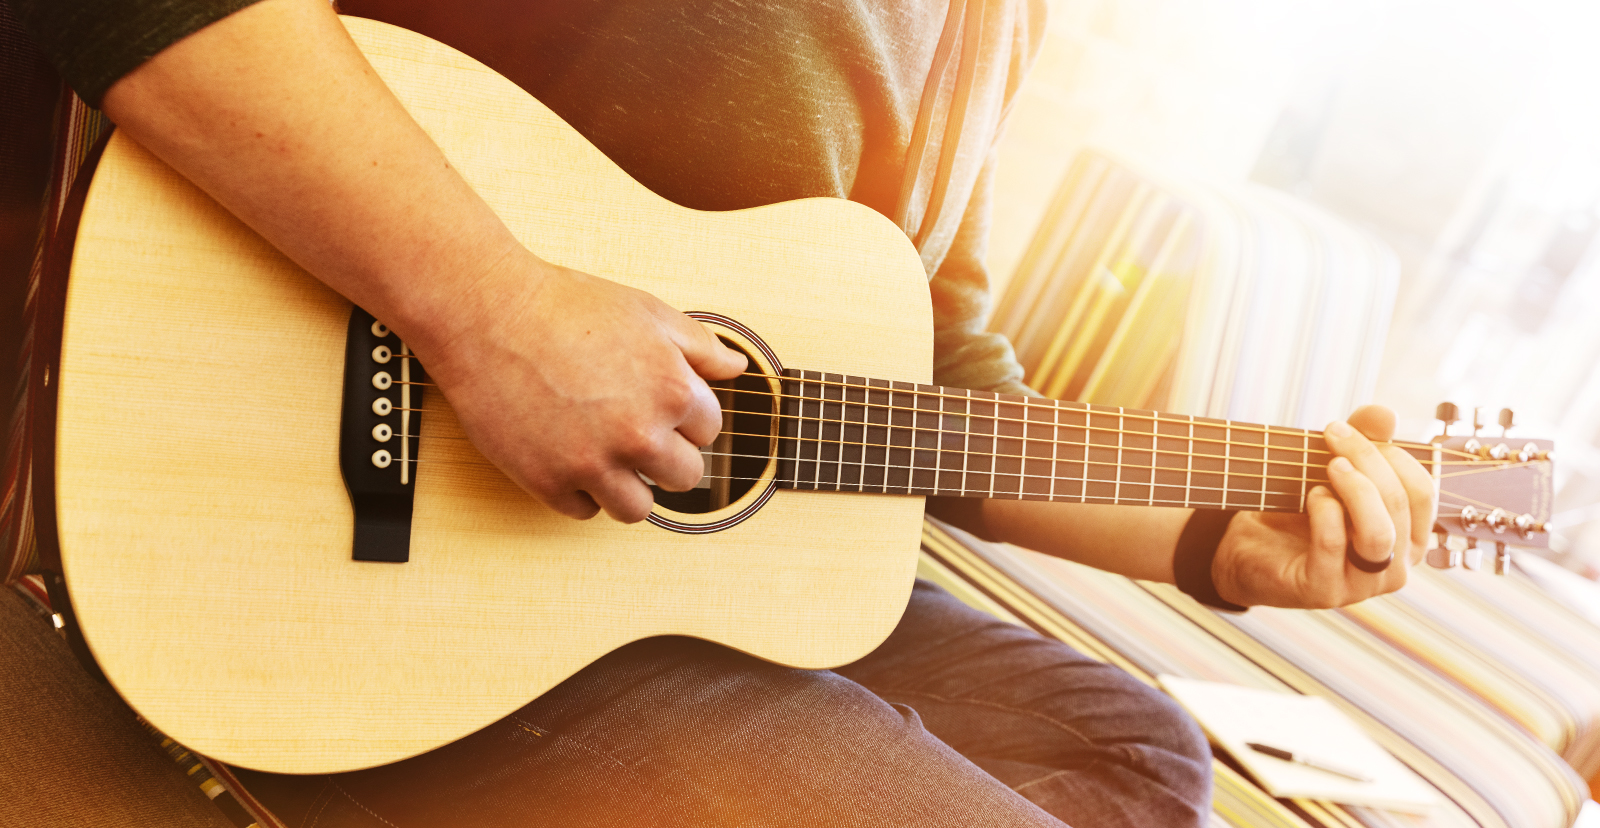

Predicted class: guitar with a 47.54


In [24]:
test= './dataset/PartB/testing/guitar1.jpg'
#Test the model on a new image
img= image.load_img(test, target_size=(224, 224))
img_array= image.img_to_array(img)
img_array= np.expand_dims(img_array, axis=0)
img_array= img_array/255

prediction= model.predict(img_array)
score= tf.nn.softmax(prediction)

#Show the image
display.display(display.Image(test))
print("Predicted class: {} with a {:.2f}".format(labels[np.argmax(score)], 100 * np.max(score)))

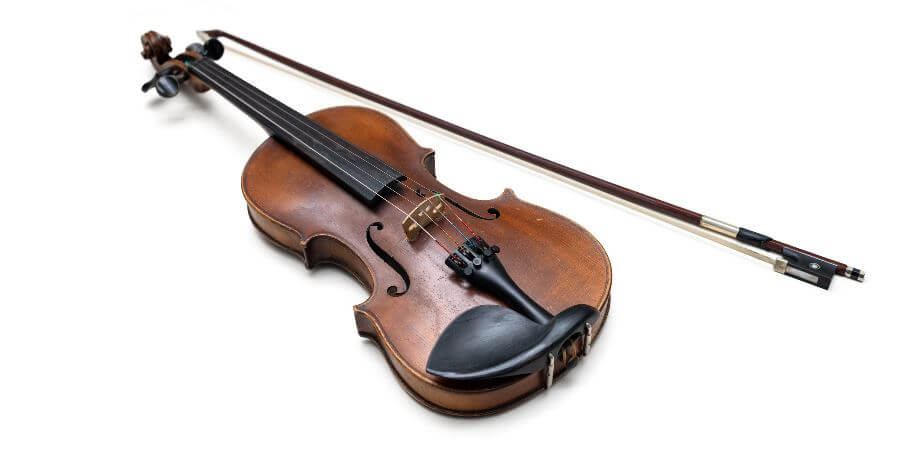

Predicted class: violin with a 47.52


In [25]:
test= './dataset/PartB/testing/violin2.jpg'
#Test the model on a new image
img= image.load_img(test, target_size=(224, 224))
img_array= image.img_to_array(img)
img_array= np.expand_dims(img_array, axis=0)
img_array= img_array/255

prediction= model.predict(img_array)
score= tf.nn.softmax(prediction)

#Show the image
display.display(display.Image(test))
print("Predicted class: {} with a {:.2f}".format(labels[np.argmax(score)], 100 * np.max(score)))

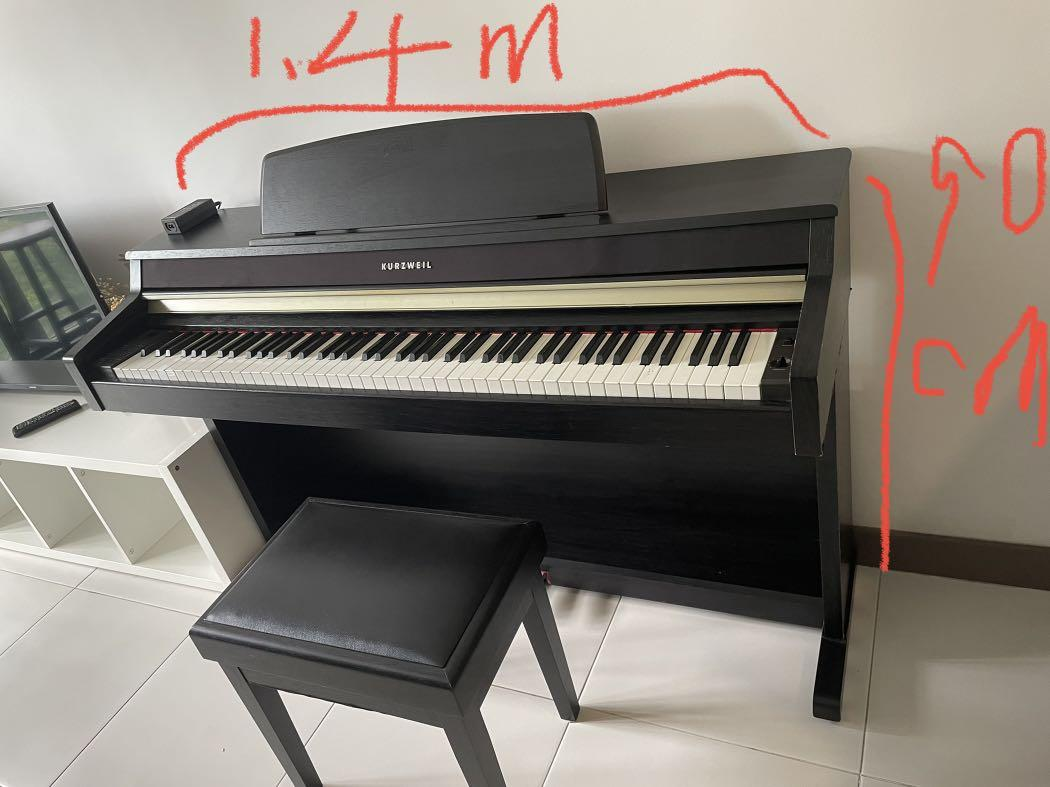

Predicted class: piano with a 47.54


In [26]:
test= './dataset/PartB/testing/piano1.jpg'
#Test the model on a new image
img = image.load_img(test, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction)

#Show the image
display.display(display.Image(test))
print("Predicted class: {} with a {:.2f}".format(labels[np.argmax(score)], 100 * np.max(score)))


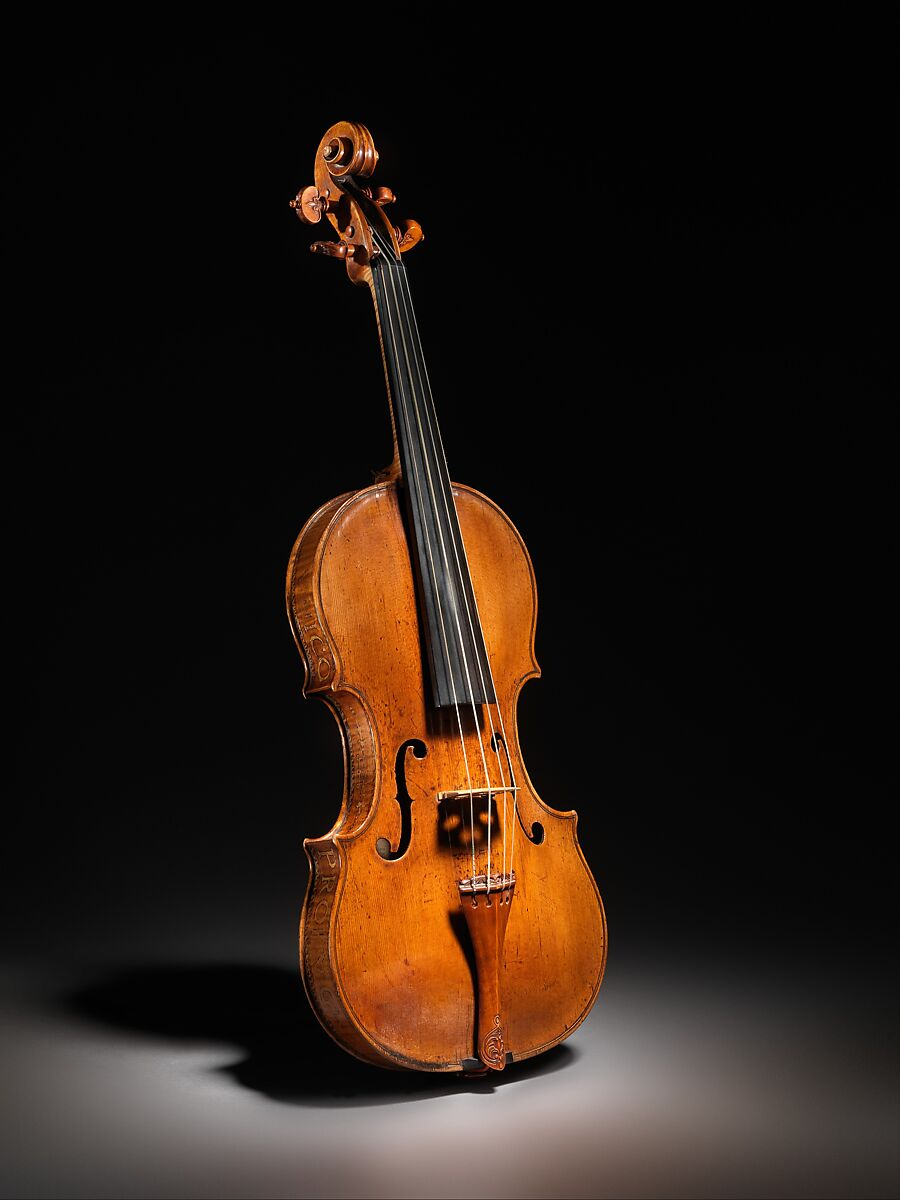

Predicted class: guitar with a 45.17


In [27]:
test= './dataset/PartB/testing/violin1.jpeg'
#Test the model on a new image
img = image.load_img(test, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction)

#Show the image
display.display(display.Image(test))
print("Predicted class: {} with a {:.2f}".format(labels[np.argmax(score)], 100 * np.max(score)))
